# Estimating $\beta$ weights: OLS vs Ridge
This week we will discuss the difference between Ordinary Least Squares (OLS) regression and Ridge regression as ways to estimate model parameters ($\beta$ weights)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from stat_utils import column_corr
%matplotlib inline

First, we will create some fake data, estimate responses to it, and predict responses in a new data set.

For now, for simplicity, we will not worry about the HRF, and we will consider a more general design that does not involve a design matrix of ones and zeros.

## Exercise 01: Make some fake data!
* Create a design matrix with 50 different channels in it, and with 290 time points (TRs, if that's clearer.)
* Generate 50 random weights for each column for each of 10 voxels
* Generate data timecourses (Y variables) for all 10 voxels (each with a different set of $\beta$ weights)
* Split the design matrix and data into training and validation sets by taking 200 time points for training and 90 time points for validation

In [51]:
# Answer

# Parameters
n_wts = 50
n_tps_trn = 200
n_tps_val = 90
n_vox = 10
noise_magnitude = 7

X = np.random.randn(n_tps_trn + n_tps_val, n_wts)
B = np.random.randn(n_wts, n_vox)
# Some noise! Otherwise it's no fun.
E = np.random.randn(n_tps_trn + n_tps_val, n_vox) * noise_magnitude
Y = X.dot(B) + E

Xtrn = X[:n_tps_trn, :]
Xval = X[n_tps_trn:, :]
Ytrn = Y[:n_tps_trn, :]
Yval = Y[n_tps_trn:, :]

Text(0.5,1,'$\\beta$')

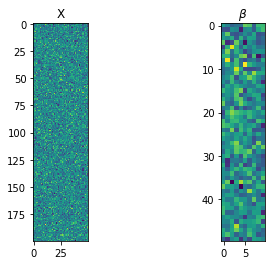

In [52]:
fig, axs = plt.subplots(1,2)
ax1, ax2 = axs
ax1.imshow(Xtrn)
ax1.set_title("X")
ax2.imshow(B)
ax2.set_title('$\\beta$')

## Exercise 02: Put the OLS function into python and estimate your weights!

The normal equation for OLS is: 

## $\beta = (X^TX)^{-1}X^TY$

Define a function: 

```python
def ols(X, Y): 
    B = ....
    return B
```
to do OLS estimation of weights for you!

Hint: to do matrix inversion, use `np.linalg.inv()`

In [53]:
# Answer
def ols(X, Y):
    B = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
    return B


In [54]:
B_est = ols(Xtrn, Ytrn)

See how well OLS estimates $\beta$ weights!

In [55]:
# Plot estimated beta weights against true beta weights
# We will use this several times, so let's define a function:
def plot_beta_comparison(B, Be):
    fig, axs = plt.subplots(5, 2, figsize=(8,6))
    # Use only training data to estimate weights
    B_est = ols(Xtrn, Ytrn)
    for b, be, ax in zip(B.T, Be.T, axs.flatten()):
        ax.plot(b)
        ax.plot(be, 'r.')
    plt.tight_layout()

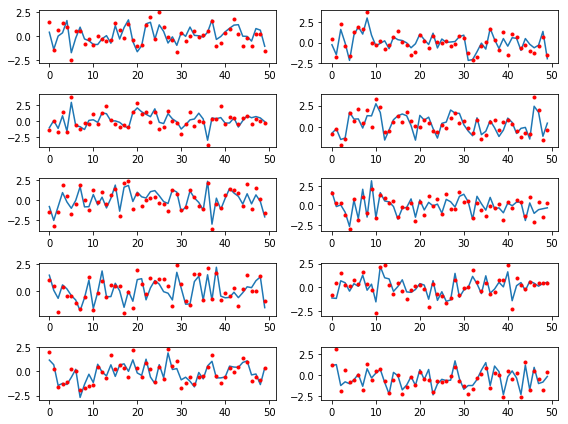

In [56]:
plot_beta_comparison(B, B_est)

# Make predictions

Compute predictions by multiplying the design matrix for the validation data (`Xval`) by the estimated weights!

(array([1., 1., 0., 1., 0., 2., 0., 2., 1., 2.]),
 array([0.49146087, 0.5092142 , 0.52696754, 0.54472087, 0.5624742 ,
        0.58022753, 0.59798087, 0.6157342 , 0.63348753, 0.65124087,
        0.6689942 ]),
 <a list of 10 Patch objects>)

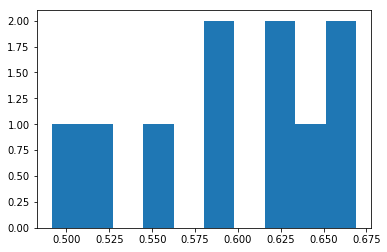

In [57]:
Y_pred = Xval.dot(B_est)
r = column_corr(Yval, Y_pred)
plt.hist(r)

(90, 10)


(0, 1)

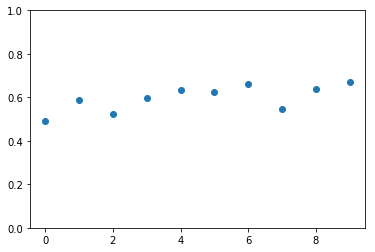

In [59]:
Y_pred = Xval.dot(B_est)
print(Y_pred.shape)
r = column_corr(Yval, Y_pred)
plt.plot(r, 'o')
plt.ylim([0, 1])
# Not bad!

# How can we mess this up? 
A simple way is to add noise! Amp up the noise above and see what happens to the estimates of the $\beta$ weights and to the predictions.

[Go do it!]

Another way to mess up the estimation of regressors is to add correlations between regressors. This is a particular problem if the correlation between your regressors is different in the training data and in the validation data (i.e., if your training data is not representative of the real world). Let's simulate this situation by creating an `Xtrn` matrix that has correlated columns (while `Xval` does not. 

## Exercise 03: Make a design matrix with correlated columns!

Call it Xc_trn (for "X correlated")

use `np.corrcoef` to compute the correlations between columns to see if you've succeeded!

In [87]:
n_wts = 1000

In [92]:
# Answer

Xc_trn = np.random.randn(n_tps_trn, n_wts)
n_correlated_columns = 300
decorr_value = 0.3
for i in range(n_correlated_columns):
    Xc_trn[:,i+1] = Xc_trn[:,0] + np.random.randn(n_tps_trn,) * decorr_value

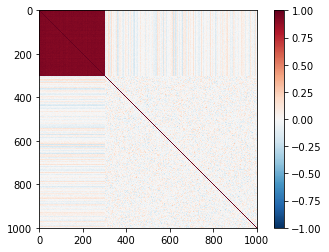

In [93]:
# Test whether you have succeeded 
plt.imshow(np.corrcoef(Xc_trn.T), vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar();
# The upper left corner of this plot should be red, indicating correlated columns of Xc_trn!

In [96]:
# Now, re-generate your training and validation data from this correlated Xc
E = np.random.randn(n_tps_trn + n_tps_val, n_vox)
B = np.random.randn(n_wts, n_vox)
Yc_trn = Xc_trn.dot(B) + E[:n_tps_trn, :] #  Use same E as above

# And keep random values of X for your validation data (no correlations between columns)
Xc_val = np.random.randn(n_tps_val, n_wts)
Yc_val = Xc_val.dot(B) + E[n_tps_trn:, :] #  Use same E as above

In [97]:
# Estimate betas
B_est_c = ols(Xc_trn, Yc_trn)

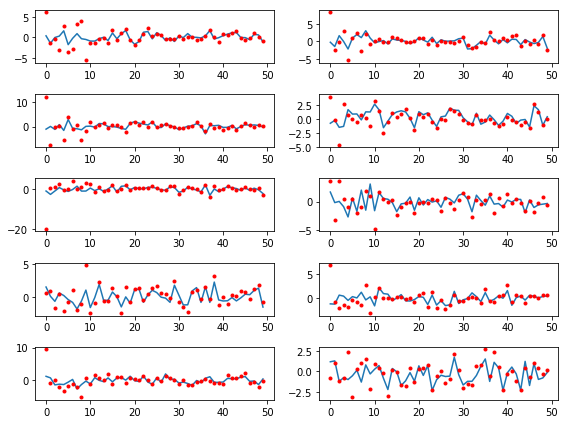

In [77]:
# And plot!
plot_beta_comparison(B, B_est_c)

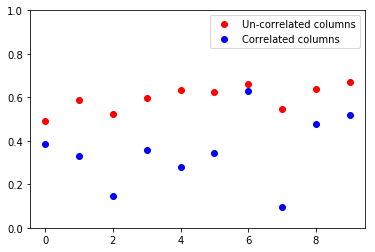

In [78]:
# Make predictions
Y_pred_c = Xc_val.dot(B_est_c)
rc = column_corr(Yc_val, Y_pred_c)
plt.plot(r, 'ro', label='Un-correlated columns')
plt.plot(rc, 'bo', label='Correlated columns')
plt.ylim([0, 1])
plt.legend()
# Messing up a little more...

## Exercise 05: Implement ridge regression 

The normal equation for ridge regression is: 
    
## $\beta = (X^TX + \lambda I)^{-1}X^TY$

In [79]:
# Answer
def ridge(X, Y, lam=100):
    nt = X.shape[1]
    B = np.linalg.inv(X.T.dot(X) + lam * np.eye(nt)).dot(X.T.dot(Y))
    return B

In [98]:
# Below you can try to figure out how to choose a lambda value
B_est_c_ridge = ridge(Xc_trn, Yc_trn, lam=1000)

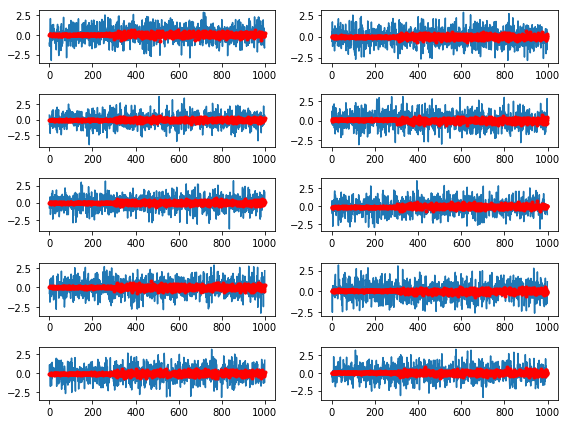

In [99]:
# The weights are smaller!
plot_beta_comparison(B, B_est_c_ridge)

In [101]:
rc_ridge.shape

(10,)

In [102]:
B_est_c_ridge.shape

(1000, 10)

(array([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]),
 array([0.31742907, 0.32156766, 0.32570624, 0.32984482, 0.33398341,
        0.33812199, 0.34226057, 0.34639916, 0.35053774, 0.35467633,
        0.35881491, 0.36295349, 0.36709208, 0.37123066, 0.37536925,
        0.37950783, 0.38364641, 0.387785  , 0.39192358, 0.39606217,
        0.40020075, 0.40433933, 0.40847792, 0.4126165 , 0.41675509,
        0.42089367, 0.42503225, 0.42917084, 0.43330942, 0.437448  ,
        0.44158659, 0.44572517, 0.44986376, 0.45400234, 0.45814092,
        0.46227951, 0.46641809, 0.47055668, 0.47469526, 0.47883384,
        0.48297243, 0.48711101, 0.4912496 , 0.49538818, 0.49952676,
        0.50366535, 0.50780393, 0.51194252, 0.5160811 , 0.52021968,
        0.52435827, 0.52849685]),
 <a list of 51 Patch objects>)

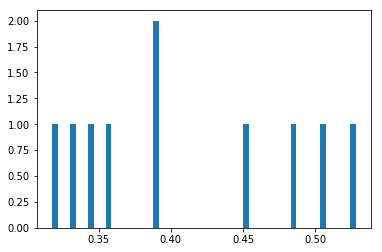

In [100]:
Y_pred_c_ridge = Xc_val.dot(B_est_c_ridge)
rc_ridge = column_corr(Yc_val, Y_pred_c_ridge)
plt.hist(rc_ridge, bins=51)

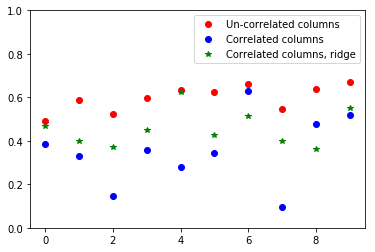

In [86]:
# Make predictions
Y_pred_c_ridge = Xc_val.dot(B_est_c_ridge)
rc_ridge = column_corr(Yc_val, Y_pred_c_ridge)
plt.plot(r, 'ro', label='Un-correlated columns')
plt.plot(rc, 'bo', label='Correlated columns')
plt.plot(rc_ridge, 'g*', label='Correlated columns, ridge')
plt.ylim([0, 1])
plt.legend()
# Messing up a little more...

In *MOST* Cases, this improves your prediction accuracy. 

## Exercise: How would you go about choosing a lambda parameter? 


Try different ones! See which works best! 

```python
# Answer
```


Write out the answer to this exercise in pseudo-code!



# If time: More demos

In [ ]:
# ...